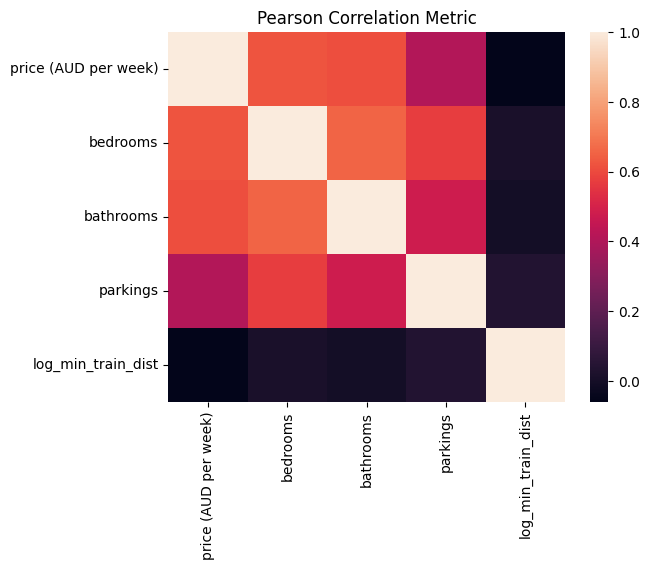

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

property_df = pd.read_csv('../data/raw/property_w_distance.csv')
property_df['log_min_train_dist'] = np.log1p(property_df['min_train_dist'])
corr_columns = [
    "price (AUD per week)", "bedrooms", "bathrooms", "parkings", "log_min_train_dist"
]

sns.heatmap(property_df[corr_columns].corr())

plt.title('Pearson Correlation Metric')
plt.savefig('../plots/pearson_corr.png', bbox_inches='tight')
plt.show()
# no strong relationship bewteen price and log_min_train_dist


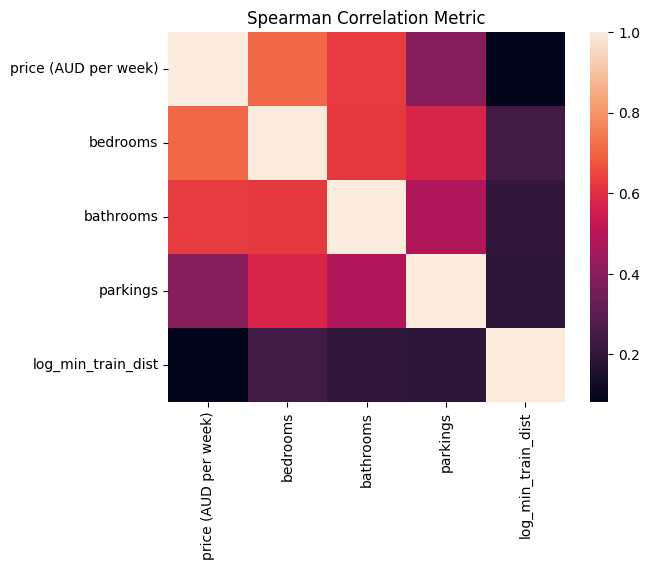

In [2]:
sns.heatmap(property_df[corr_columns].corr(method='spearman'))
plt.title('Spearman Correlation Metric')
plt.savefig('../plots/spearmans_corr.png', bbox_inches='tight')
plt.show()

# still no strong relationship bewteen price and log_min_train_dist

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Rename the 'price (AUD per week)' column
property_df = property_df.rename(columns={'price (AUD per week)': 'price_per_week'})
# Rename the 'property type' column
property_df = property_df.rename(columns={'property type': 'property_type'})

# test effect of suburb on rental price
model_suburb = ols('price_per_week ~ C(suburb)', data=property_df).fit()

anova_suburb = sm.stats.anova_lm(model_suburb, typ=2)
print(anova_suburb)

# there is a statistically significant effect of suburb on rental price

# test effect of property type on rental price
model_type = ols('price_per_week ~ C(property_type)', data=property_df).fit()

anova_type = sm.stats.anova_lm(model_type, typ=2)
print(anova_type)

# there is a statistically significant effect of property type on rental price


                 sum_sq     df         F    PR(>F)
C(suburb)  2.655413e+07  154.0  1.522675  0.000172
Residual   9.455635e+07  835.0       NaN       NaN
                        sum_sq     df          F        PR(>F)
C(property_type)  2.272823e+07    6.0  37.848711  1.878596e-41
Residual          9.838225e+07  983.0        NaN           NaN


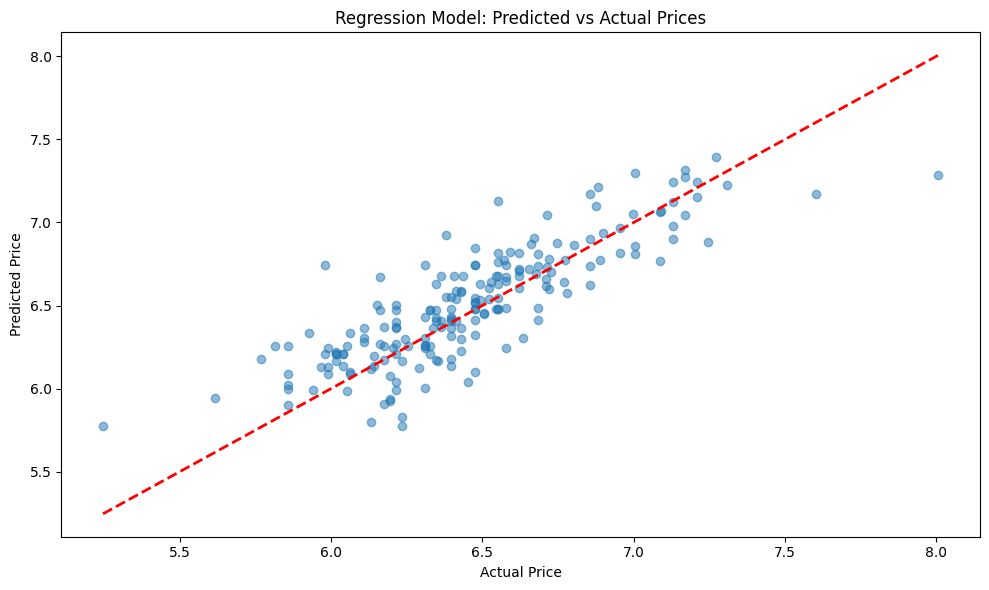

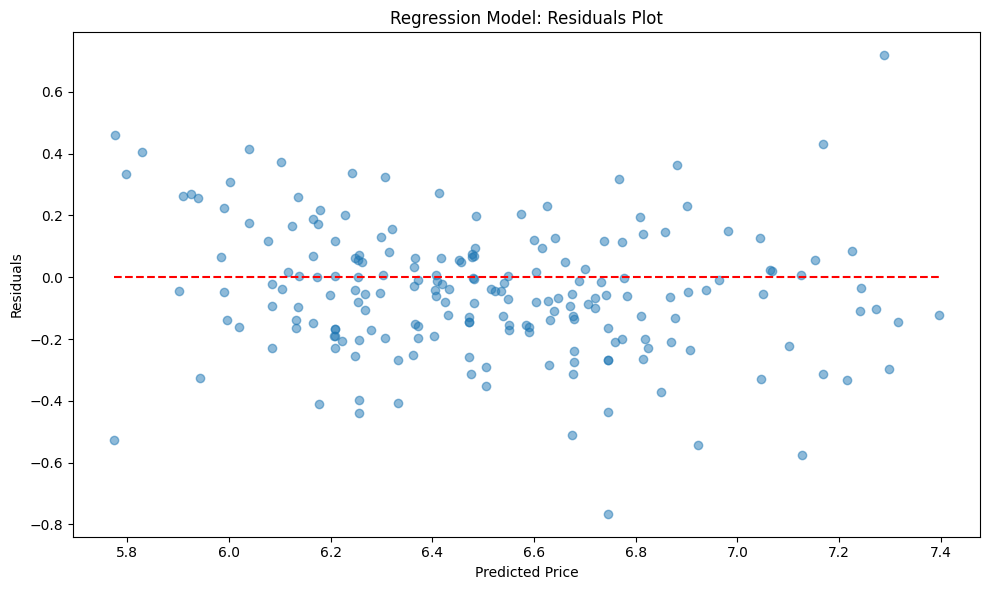

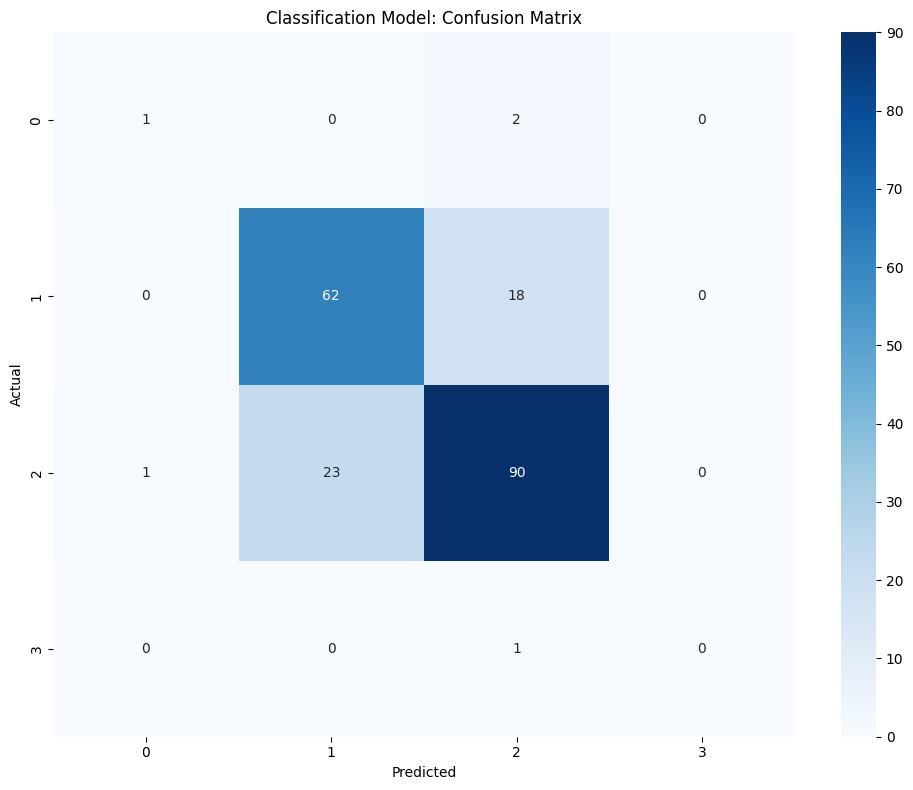

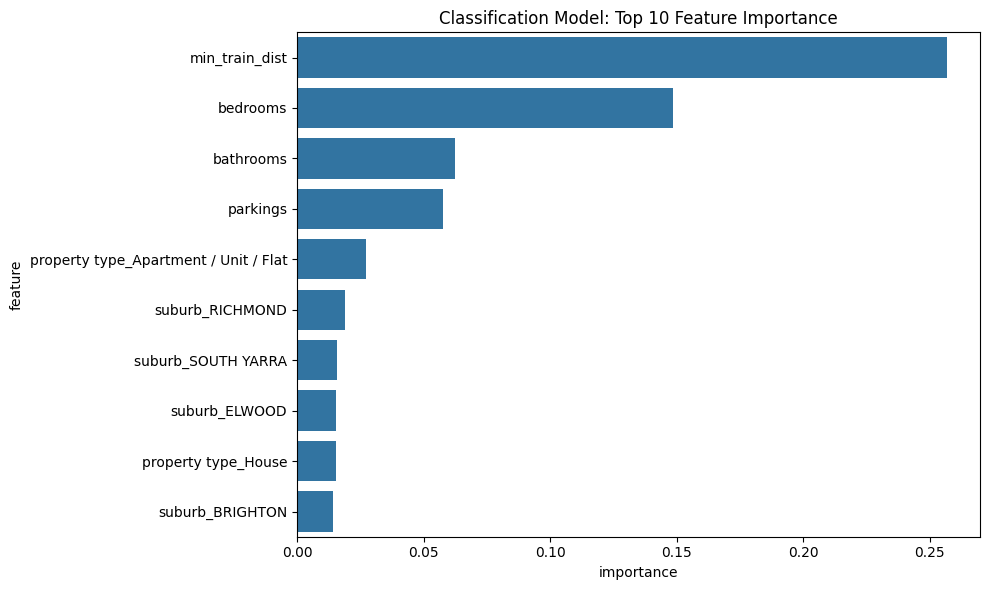

Regression Model Performance:
Mean Squared Error: 0.05
R-squared Score: 0.68

Classification Model Performance:
Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

        High       0.50      0.33      0.40         3
         Low       0.73      0.78      0.75        80
      Medium       0.81      0.79      0.80       114
   Very High       0.00      0.00      0.00         1

    accuracy                           0.77       198
   macro avg       0.51      0.47      0.49       198
weighted avg       0.77      0.77      0.77       198



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
# Load the data
data = pd.read_csv('../data/curated/processed property_w_distance.csv')


# Clean and preprocess the data
data['price'] = data['price (AUD per week)']
data['log_rental_price'] = np.log(data['price'])
data['bedrooms'] = data['bedrooms'].fillna(0)

# Create price categories for classification
data['price_category'] = pd.cut(data['price per bedroom'], bins=[0, 300, 600, 900, np.inf],
                                labels=['Low', 'Medium', 'High', 'Very High'])

# Split features and target
X = data[['bedrooms', 'bathrooms', 'parkings', 'property type', 'suburb', 'min_train_dist']]
y_regression = data['log_rental_price']
y_classification = data['price_category']

# Split the data
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_regression, y_classification, test_size=0.2, random_state=42)

# Create preprocessor
numeric_features = ['bedrooms', 'bathrooms', 'parkings', 'min_train_dist']
categorical_features = ['property type', 'suburb']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Regression Model
reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

reg_model.fit(X_train, y_reg_train)
y_reg_pred = reg_model.predict(X_test)

# Classification Model
class_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

class_model.fit(X_train, y_class_train)
y_class_pred = class_model.predict(X_test)

# Visualization 1: Regression Model - Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Regression Model: Predicted vs Actual Prices')
plt.tight_layout()
plt.show()

# Visualization 2: Regression Model - Residuals Plot
residuals = y_reg_test - y_reg_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_reg_pred.min(), xmax=y_reg_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Regression Model: Residuals Plot')
plt.tight_layout()
plt.show()

# Visualization 3: Classification Model - Confusion Matrix
cm = confusion_matrix(y_class_test, y_class_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Model: Confusion Matrix')
plt.tight_layout()
plt.show()

# Visualization 4: Classification Model - Feature Importance
feature_importance = class_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features +
                 class_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Classification Model: Top 10 Feature Importance')
plt.tight_layout()
plt.show()

# Print model performance metrics
print("Regression Model Performance:")
print(f"Mean Squared Error: {mean_squared_error(y_reg_test, y_reg_pred):.2f}")
print(f"R-squared Score: {r2_score(y_reg_test, y_reg_pred):.2f}")

print("\nClassification Model Performance:")
print(f"Accuracy: {class_model.score(X_test, y_class_test):.2f}")
print("\nClassification Report:")
print(classification_report(y_class_test, y_class_pred))

In [5]:

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report


# Initialize and train new models
simple_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

simple_class_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

complex_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

complex_class_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Fit the models
simple_reg_model.fit(X_train, y_reg_train)
complex_reg_model.fit(X_train, y_reg_train)
simple_class_model.fit(X_train, y_class_train)
complex_class_model.fit(X_train, y_class_train)

# Predictions
y_simple_reg_pred = simple_reg_model.predict(X_test)
y_complex_reg_pred = complex_reg_model.predict(X_test)
y_simple_class_pred = simple_class_model.predict(X_test)
y_complex_class_pred = complex_class_model.predict(X_test)

# Evaluation
# Regression Model Performance (Simple and Complex)
simple_reg_mse = mean_squared_error(y_reg_test, y_simple_reg_pred)
simple_reg_r2 = r2_score(y_reg_test, y_simple_reg_pred)

complex_reg_mse = mean_squared_error(y_reg_test, y_complex_reg_pred)
complex_reg_r2 = r2_score(y_reg_test, y_complex_reg_pred)

# Classification Model Performance (Simple and Complex)
simple_class_report = classification_report(y_class_test, y_simple_class_pred, output_dict=True)
complex_class_report = classification_report(y_class_test, y_complex_class_pred, output_dict=True)

# Prepare the comparison table for regression
regression_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Gradient Boosting'],
    'MSE': [mean_squared_error(y_reg_test, y_reg_pred), simple_reg_mse, complex_reg_mse],
    'R-squared': [r2_score(y_reg_test, y_reg_pred), simple_reg_r2, complex_reg_r2]
})

# Prepare the comparison table for classification
classification_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'Gradient Boosting'],
    'Accuracy': [class_model.score(X_test, y_class_test), simple_class_model.score(X_test, y_class_test), complex_class_model.score(X_test, y_class_test)],
    'Precision (Weighted Avg)': [simple_class_report['weighted avg']['precision'], simple_class_report['weighted avg']['precision'], complex_class_report['weighted avg']['precision']],
    'Recall (Weighted Avg)': [simple_class_report['weighted avg']['recall'], simple_class_report['weighted avg']['recall'], complex_class_report['weighted avg']['recall']]
})




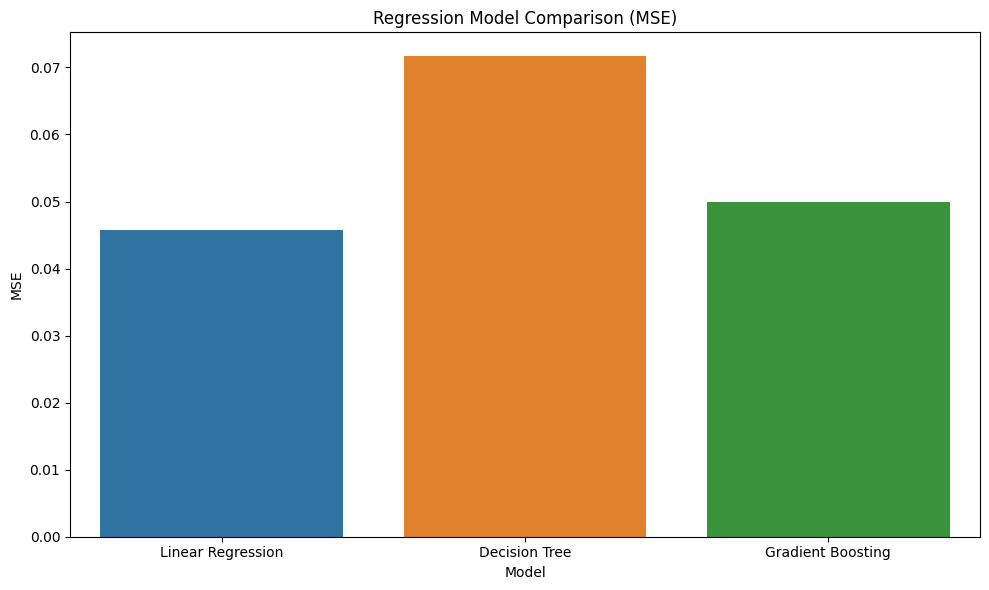

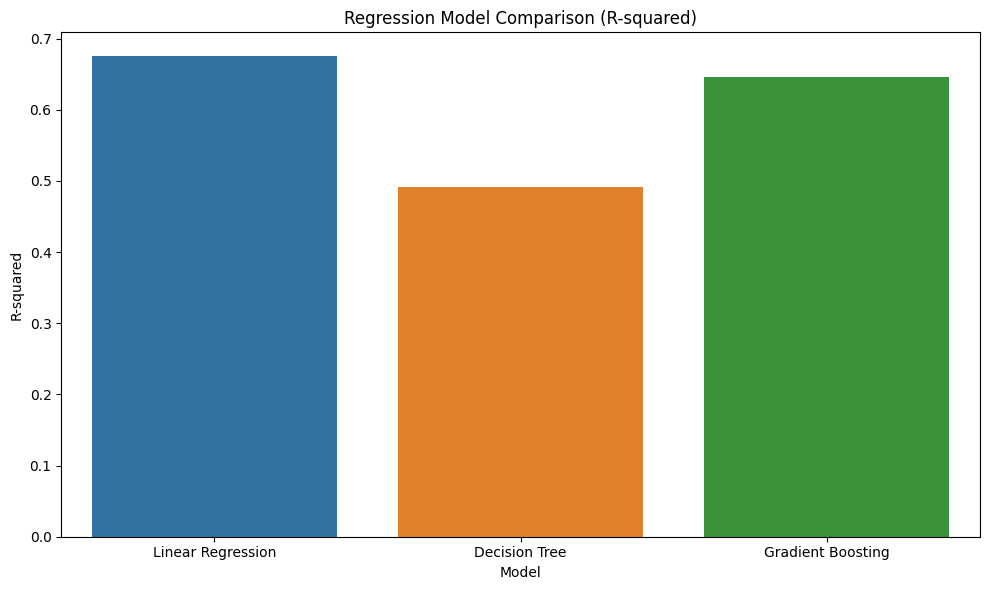

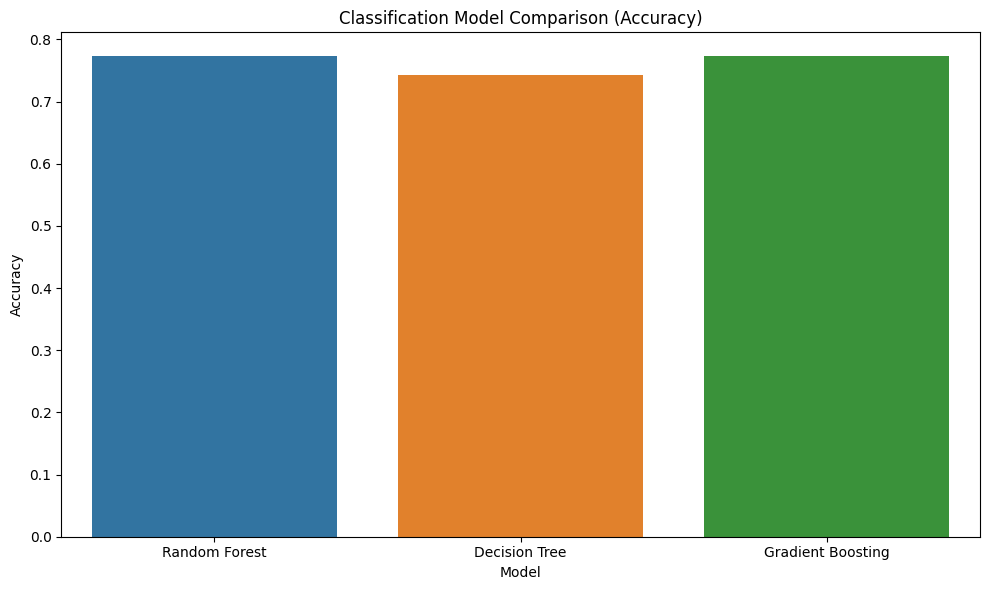

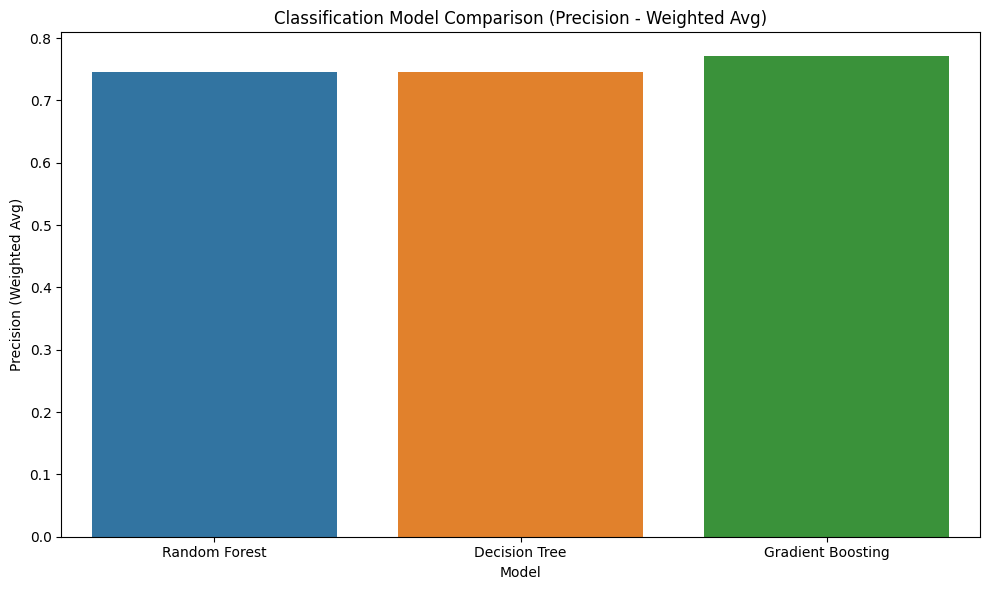

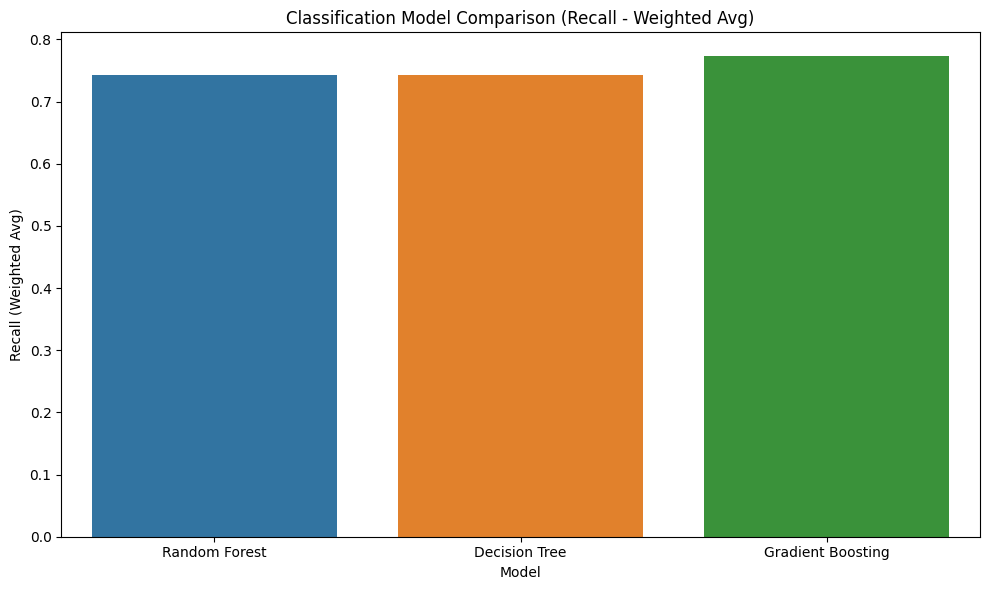

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the regression model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="MSE", data=regression_comparison, hue="Model")
plt.title("Regression Model Comparison (MSE)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="R-squared", data=regression_comparison, hue="Model")
plt.title("Regression Model Comparison (R-squared)")
plt.tight_layout()
plt.show()

# Plotting the classification model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=classification_comparison, hue="Model")
plt.title("Classification Model Comparison (Accuracy)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Precision (Weighted Avg)", data=classification_comparison, hue="Model")
plt.title("Classification Model Comparison (Precision - Weighted Avg)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Recall (Weighted Avg)", data=classification_comparison, hue="Model")
plt.title("Classification Model Comparison (Recall - Weighted Avg)")
plt.tight_layout()
plt.show()
